In [2]:
# depedencies
import getpass
from topolib.subsetDat import subsetBBox;
from topolib import IceSat2Data;
import glob
from topolib import gda_lib;
from topolib import dwnldArctic
import numpy as np
import geopandas as gpd
from multiprocessing import Pool
import rasterio as rio
from rasterio.plot import plotting_extent
import rasterio.plot
import numpy as np
#from topolib.subsetDat import subsetBBox;
from pyproj import Proj, transform
from icepyx import icesat2data as ipd

Pflug example script showing data comparison between IceSat2 ATL06 and a reference ground DEM employing tools in the topolib library

ONLY ADJUST PARAMETERS IN THIS CELL!!!!

In [3]:
# inputs
# if want to explcitly define bounding box, raster = None
datafolder = '/home/jovyan/shared/data-aragon/'
datafolderOut = '/home/jovyan/shared/data-aragon/ATL06/' #'/home/jovyan/SeasonalSnow/contributors/Jawairia/'

#if have raster define raster, if not, use None
raster = datafolder+'ASO_3M_PCDTM_USCOGE_20180908_20180913.tif'
# raster = None
# if defining extent using the raster, then rasterBnd = 1, else rasterBnd = 2
rasterBnd = 1

if rasterBnd == None:
    # Area of interest
    boundaries = {
        'LowerLeft_Lon': '-120.6',
        'LowerLeft_Lat': '37.7',
        'UpperRight_Lon': '-119.0',
        'UpperRight_Lat': '38.94',
    }

# Specify the variables of interest
LIce_var = ['atl06_quality_summary','delta_time','h_li','hli_sigma',\
           'latitude','longitude','segment_id','sigma_geo_h']
variables = {
    'beams': [
        '/land_ice_segments/'+LIce_var[0],
        '/land_ice_segments/'+LIce_var[1],
        '/land_ice_segments/'+LIce_var[2],
        '/land_ice_segments/'+LIce_var[3],
        '/land_ice_segments/'+LIce_var[4],
        '/land_ice_segments/'+LIce_var[5],
        '/land_ice_segments/'+LIce_var[6],
        '/land_ice_segments/'+LIce_var[7],
        '/ancillary_data/atlas_sdp_gps_epoch',
    ],
    'other': [
        '/orbit_info/cycle_number',
        '/orbit_info/rgt',
        '/orbit_info/orbit_number',
    ]
}

# Custom time range of interest
# define full_per = 1
full_per = 1
time_range = {
        'start_date': '2019-8-01',
        'end_date': '2019-09-20'
}

# Enter your Earthdata Login user name
user_id = 'jawairiaahmad'
# Enter your email address associated with your Earthdata Login account
email = 'jahmad@umd.edu'

In [4]:
def subsetBBox(rast,proj_in,proj_out):

    # rasterio open data
    rB = rio.open(rast)
    # rasterio get bounding box
    [L,B,R,T] = rB.bounds

    if proj_in == proj_out:
        return L, R, T, B
    else:
        incord = Proj(init=proj_in)
        outcord = Proj(init=proj_out)

        [Left,Bottom] = transform(incord,outcord,L,B)
        [Right,Top] = transform(incord,outcord,R,T)
        return Left, Bottom, Right, Top

In [5]:
import os
import shutil
from pprint import pprint
%matplotlib inline

In [6]:
#path to raster
raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCOGE_20180908_20180913.tif'
ds = rasterio.open(raster_path)
dem = ds.read(1)
xmin,ymin,xmax,ymax = ds.bounds
ds.crs
raster = rio.open(raster_path)
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 15408,
 'height': 17213,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(3.0, 0.0, 305139.0,
        0.0, -3.0, 4330251.0)}

In [7]:
[L,B,R,T] = subsetBBox(raster_path,raster.crs,'epsg:4326') # now read projection from DEM, convert to WGS84
    #[L,B,R,T] = subsetBBox(raster,'epsg:32611','epsg:4326')
    # Area of interest
boundaries = {
    'LowerLeft_Lon': L,
    'LowerLeft_Lat': B,
    'UpperRight_Lon': R,
    'UpperRight_Lat': T,
}
L,B,R,T

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.

(-107.23874631976949, 38.63464885493824, -106.71910739616895, 39.108744441981)

In [8]:
# glob to list of files
ATL06_list = glob.glob(datafolderOut+'*.h5')[0]

In [9]:
# del ATL06_list[2] # x.to_crs crashed on this file
ATL06_list

'/home/jovyan/shared/data-aragon/ATL06/processed_ATL06_20190805203605_05920406_003_01.h5'

In [2]:
# read hdf5 into a geodataframe
# dataset_dict={'land_ice_segments':LIce_var, 'land_ice_segments/ground_track':['x_atc']}

In [13]:
! cd ..; [ -d pointCollection ] || git clone https://www.github.com/smithB/pointCollection.git
! sys.path.append(os.path.join(os.getcwd(), '..'))
import pointCollection as pc

def atl06_to_dict(filename, beam, field_dict=None, index=None, epsg=None):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            beam: a string specifying which beam is to be read (ex: gt1l, gt1r, gt2l, etc)
            field_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
            index: which entries in each field to read
            epsg: an EPSG code specifying a projection (see www.epsg.org).  Good choices are:
                for Greenland, 3413 (polar stereographic projection, with Greenland along the Y axis)
                for Antarctica, 3031 (polar stereographic projection, centered on the Pouth Pole)
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a numpy array containing the 
                data
    """
    if field_dict is None:
        field_dict={None:['latitude','longitude','h_li', 'atl06_quality_summary'],\
                    'ground_track':['x_atc','y_atc'],\
                    'fit_statistics':['dh_fit_dx', 'dh_fit_dy']}
    D={}
    file_re=re.compile('ATL06_(?P<date>\d+)_(?P<rgt>\d\d\d\d)(?P<cycle>\d\d)(?P<region>\d\d)_(?P<release>\d\d\d)_(?P<version>\d\d).h5')
    with h5py.File(filename,'r') as h5f:
        for key in field_dict:
            for ds in field_dict[key]:
                if key is not None:
                    ds_name=beam+'/land_ice_segments/'+key+'/'+ds
                else:
                    ds_name=beam+'/land_ice_segments/'+ds
                if index is not None:
                    D[ds]=np.array(h5f[ds_name][index])
                else:
                    D[ds]=np.array(h5f[ds_name])
                if '_FillValue' in h5f[ds_name].attrs:
                    bad_vals=D[ds]==h5f[ds_name].attrs['_FillValue']
                    D[ds]=D[ds].astype(float)
                    D[ds][bad_vals]=np.NaN
    if epsg is not None:
        xy=np.array(pyproj.proj.Proj(epsg)(D['longitude'], D['latitude']))
        D['x']=xy[0,:].reshape(D['latitude'].shape)
        D['y']=xy[1,:].reshape(D['latitude'].shape)
    temp=file_re.search(filename)
    D['rgt']=int(temp['rgt'])
    D['cycle']=int(temp['cycle'])
    D['beam']=beam
    return D

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


ModuleNotFoundError: No module named 'pointCollection'

In [11]:
# find the matching ATL06 file
D6=atl06_to_dict(ATL06_list,'/gt2l', index=None, epsg=3031)

NameError: name 're' is not defined

In [10]:
## add recursively
ATL06_gdf_list = [gda_lib.ATL06_2_gdf(x,dataset_dict) for x in ATL06_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]
ATL06_gdf_list;
big_gdf = gda_lib.concat_gdf(ATL06_gdf_list)

/home/jovyan/topohack/topolib/gda_lib.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as h5f:
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
#plot DEM and overlapping ATL06 lines
%matplotlib inline
import matplotlib.pyplot as plt 
%matplotlib widget
from matplotlib import rcParams
rcParams["font.size"] = 14

fig,ax = plt.subplots(figsize=(10,8))
#rio.plot.show(dem, ax=ax,cmap='gray')
im = ax.imshow(dem,cmap='gray',extent=[xmin,xmax,ymin,ymax])
#ATL06_gdf_list[1].plot(ax=ax)
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# separate flight tracks for line-by-line comparison
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[1].groupby(ATL06_gdf_list[1]['p_b'])] #pick 1 ATL06 and seperate it into 6
df_list = [df1,df2,df3,df4,df5,df6]

In [13]:
# comparison of ground data and ATL06 using a 20m buffer sampler
# colors represent the flight lines shown above
df_test_big = gda_lib.buffer_sampler(ds,big_gdf,20,ret_gdf=True)
df_test_big['snow_on_off'] = df_test_big['h_li']-df_test_big['med']

fig,ax = plt.subplots()
for gdf in df_list:
    df_test = gda_lib.buffer_sampler(ds,gdf,20,ret_gdf=True)
    df_test['snow_on_off'] = df_test['h_li']-df_test['med']
    ax.scatter(df_test['latitude'],df_test['snow_on_off'])
    print(df_test['snow_on_off'].mean(),df_test['snow_on_off'].std(),100*df_test['snow_on_off'].mean()/(df_test['h_li'].max()-df_test['h_li'].min()))
# df_test['snow_on_off'].hist(bins=30)
# ax.scatter(df_test['latitude'],df_test['snow_on_off'])

big_gdf['diff'] = df_test_big['snow_on_off']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1.1417288052833687 3.401035110129676 0.10702486829788957
1.0858479133841037 3.5954898930956114 0.1009692085072961
0.30513713912458607 1.5688987866114494 0.028334149577785944
0.3634575109331557 1.1535595150871822 0.030137548535418248
0.7141448974609375 2.7713516831204874 0.04940332038886439
0.6370107444799002 3.720452229161687 0.044110267882372066


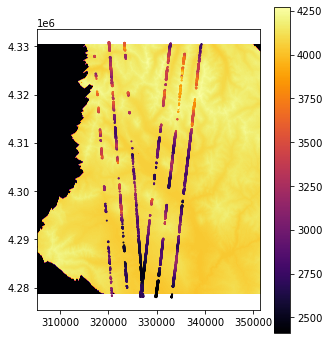

In [15]:
# point-by-point comparison
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(dem,cmap='inferno',extent=[xmin,xmax,ymin,ymax])
big_gdf.plot('h_li',legend=True,ax=ax,cmap='inferno',s=1)

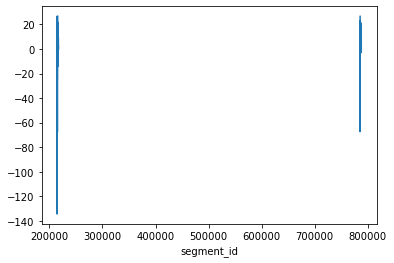

In [16]:
# example for grouping by segment id number
big_gdf.groupby('segment_id').median()['diff'].plot()

In [21]:
# rasterio instance
ds2 = rasterio.open('/home/jovyan/data/slope.tif')
slp = ds2.read(1)
slp = np.ma.masked_equal(slp,gda_lib.get_ndv(ds2))
xmin,ymin,xmax,ymax = ds2.bounds
ds2.crs

ds3 = rasterio.open('/home/jovyan/data/aspect.tif')
asp = ds3.read(1)
asp = np.ma.masked_equal(asp,gda_lib.get_ndv(ds3))
xmin,ymin,xmax,ymax = ds3.bounds
ds3.crs

CRS.from_epsg(32611)

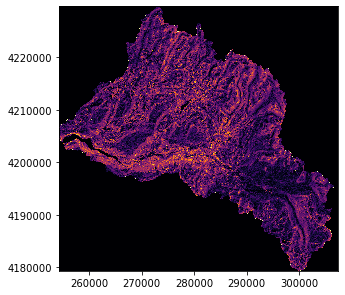

In [22]:
# visualize data
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(slp,cmap='inferno',extent=[xmin,xmax,ymin,ymax])

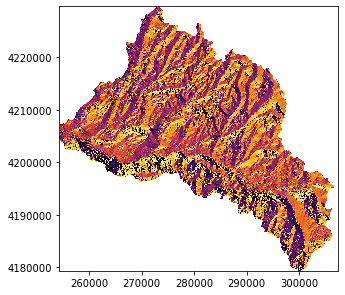

In [23]:
# visualize data
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(asp,cmap='inferno',extent=[xmin,xmax,ymin,ymax])

In [24]:
# sample data along same ground tracks
df_test_big_slp = gda_lib.buffer_sampler(ds2,big_gdf,20,ret_gdf=True)
good_idx = df_test_big['atl06_quality_summary']==0
df_test_big = df_test_big.loc[good_idx]

df_test_big_asp = gda_lib.buffer_sampler(ds3,big_gdf,20,ret_gdf=True)

Text(0.5, 0, 'Slope [deg]')

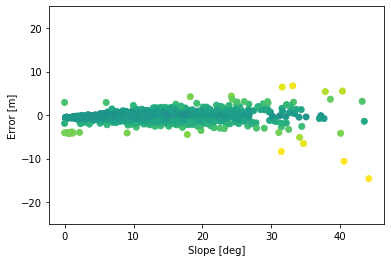

In [25]:
df_test_big_slp = df_test_big_slp.loc[good_idx]
fig,ax = plt.subplots()
ax.scatter(df_test_big_slp['med'],df_test_big['snow_on_off'],\
          c=abs(df_test_big['snow_on_off']),vmin=-7,vmax=7)
plt.ylim(-25,25)
plt.ylabel('Error [m]')
plt.xlabel('Slope [deg]')